# TWFE Robustness and Sensitivity Analysis

## Executive Summary

This notebook performs robustness checks on the TWFE Difference-in-Differences regression from Notebook 02.

**What we validate:**
- Standard error robustness (clustered vs. robust variants)
- Outlier sensitivity (winsorization)
- Leave-one-household-out (LOHO) sensitivity
- Placebo pre-period test

**Inputs:**
- `data/intermediate/did_campaign_panel_purchase.parquet`

**Outputs:**
- Robustness tables and figures in `results/modeling/robustness/`
- Run manifest in `results/run_manifests/`


## Imports + Logging


In [1]:
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime, timezone
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("causal_analytics.notebook06_robustness")

%matplotlib inline
sns.set_theme(style="whitegrid", context="talk")

print(f"Python executable: {sys.executable}")


Python executable: /Users/rajnishpanwar/.venv/bin/python


## Repo Root + Paths


In [2]:
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(12):
        if (p / "README.md").exists():
            return p
        p = p.parent
    raise RuntimeError("Repository root not found (README.md missing)")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_DIR = REPO_ROOT / "data" / "intermediate"
OUT_DIR = REPO_ROOT / "results" / "modeling" / "robustness"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"
RUN_MANIFESTS_DIR = REPO_ROOT / "results" / "run_manifests"

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
RUN_MANIFESTS_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Repository root: {REPO_ROOT}")


2026-01-14 18:41:29,445 - INFO - Repository root: /Users/rajnishpanwar/Desktop/Casual Analytics


## Load Data + Gates + Summary


In [3]:
np.random.seed(42)

panel_file = DATA_DIR / "did_campaign_panel_purchase.parquet"
if not panel_file.exists():
    raise FileNotFoundError(f"Panel file not found: {panel_file}")

df_panel = pd.read_parquet(panel_file)
logger.info(f"Loaded panel: {len(df_panel)} rows, {len(df_panel.columns)} columns")

required_cols = ["campaign_id", "household_id", "week_number", "rel_week", "anchor_week", "treated", "post", "total_sales_value", "total_units"]
missing_cols = [col for col in required_cols if col not in df_panel.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

df_panel["did"] = df_panel["treated"] * df_panel["post"]

df_panel["y_sales"] = df_panel["total_sales_value"]
df_panel["y_log_sales"] = np.log1p(df_panel["total_sales_value"].clip(lower=0))
df_panel["y_units"] = df_panel["total_units"]

n_rows = len(df_panel)
n_households = df_panel["household_id"].nunique()
n_campaigns = df_panel["campaign_id"].nunique()
treated_row_share = df_panel["treated"].sum() / n_rows
treated_household_count = df_panel.groupby("household_id")["treated"].max().sum()

logger.info(f"Panel summary: {n_rows} rows, {n_households} households, {n_campaigns} campaigns")
logger.info(f"Treated share (rows): {treated_row_share:.2%}")
logger.info(f"Treated households: {treated_household_count}")

df_2x2_rows = pd.crosstab(df_panel["treated"], df_panel["post"], margins=True)
logger.info(f"2x2 structure (rows):\n{df_2x2_rows}")

df_2x2_hh = df_panel.groupby(["household_id", "treated", "post"]).size().reset_index(name="count")
df_2x2_hh_summary = pd.crosstab(df_2x2_hh["treated"], df_2x2_hh["post"], margins=True)
logger.info(f"2x2 structure (households):\n{df_2x2_hh_summary}")


2026-01-14 18:41:39,028 - INFO - Loaded panel: 122536 rows, 11 columns
2026-01-14 18:41:39,033 - INFO - Panel summary: 122536 rows, 30 households, 1584 campaigns
2026-01-14 18:41:39,033 - INFO - Treated share (rows): 0.71%
2026-01-14 18:41:39,033 - INFO - Treated households: 15
2026-01-14 18:41:39,048 - INFO - 2x2 structure (rows):
post         0      1     All
treated                      
0        57256  64413  121669
1          408    459     867
All      57664  64872  122536
2026-01-14 18:41:39,056 - INFO - 2x2 structure (households):
post      0   1  All
treated             
0        30  30   60
1        15  15   30
All      45  45   90


## Baseline TWFE (Clustered)


In [4]:
def run_twfe(df: pd.DataFrame, outcome_col: str, cluster_col: str = "household_id", cov_type: str = "cluster", cov_kwds: Dict = None):
    y = df[outcome_col].values
    
    X_did = pd.DataFrame({"did": df["did"].astype(float)})
    X_hh = pd.get_dummies(df["household_id"], prefix="hh", drop_first=True, dtype=float)
    X_week = pd.get_dummies(df["week_number"], prefix="week", drop_first=True, dtype=float)
    
    X = pd.concat([X_did, X_hh, X_week], axis=1)
    X = add_constant(X, prepend=False)
    X = X.astype(float)
    
    param_names = X.columns.tolist()
    
    if cov_kwds is None:
        cov_kwds = {"groups": df[cluster_col]}
    
    model = OLS(y, X)
    result = model.fit(cov_type=cov_type, cov_kwds=cov_kwds)
    
    result.param_names = param_names
    
    return result

outcomes = ["y_sales", "y_log_sales", "y_units"]
baseline_results = {}

for outcome in outcomes:
    logger.info(f"Fitting baseline TWFE for {outcome}")
    result = run_twfe(df_panel, outcome)
    baseline_results[outcome] = result
    
    did_idx = result.param_names.index("did")
    coef = result.params.iloc[did_idx]
    se = result.bse.iloc[did_idx]
    pval = result.pvalues.iloc[did_idx]
    ci_low = result.conf_int().iloc[did_idx, 0]
    ci_high = result.conf_int().iloc[did_idx, 1]
    
    logger.info(f"  DID coef: {coef:.4f}, SE: {se:.4f}, p-value: {pval:.4f}")

baseline_table = []
for outcome in outcomes:
    result = baseline_results[outcome]
    did_idx = result.param_names.index("did")
    baseline_table.append({
        "outcome": outcome,
        "coef": result.params.iloc[did_idx],
        "se_clustered": result.bse.iloc[did_idx],
        "pvalue": result.pvalues.iloc[did_idx],
        "ci_low": result.conf_int().iloc[did_idx, 0],
        "ci_high": result.conf_int().iloc[did_idx, 1],
        "nobs": result.nobs,
        "n_clusters": df_panel["household_id"].nunique()
    })

df_baseline = pd.DataFrame(baseline_table)
df_baseline.to_csv(TABLE_DIR / "twfe_baseline.csv", index=False)

print(df_baseline)


2026-01-14 18:41:47,662 - INFO - Fitting baseline TWFE for y_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 18:41:48,741 - INFO -   DID coef: 21.0017, SE: 7.6717, p-value: 0.0062
2026-01-14 18:41:48,741 - INFO - Fitting baseline TWFE for y_log_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 18:41:49,649 - INFO -   DID coef: 0.7284, SE: 0.2667, p-value: 0.0063
2026-01-14 18:41:49,650 - INFO - Fitting baseline TWFE for y_units
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 18:41:50,622 - INFO -   DID coef: 86

       outcome        coef  se_clustered    pvalue       ci_low      ci_high  \
0      y_sales   21.001736      7.671667  0.006189     5.965545    36.037927   
1  y_log_sales    0.728393      0.266701  0.006312     0.205668     1.251117   
2      y_units  868.520289   1122.289630  0.439000 -1331.126966  3068.167544   

       nobs  n_clusters  
0  122536.0          30  
1  122536.0          30  
2  122536.0          30  


## SE Variants (Cluster vs HC1 vs HC3)


In [8]:
se_variants = []

for outcome in outcomes:
    logger.info(f"Fitting SE variants for {outcome}")
    
    result_cluster = run_twfe(df_panel, outcome, cov_type="cluster", cov_kwds={"groups": df_panel["household_id"]})
    result_hc1 = run_twfe(df_panel, outcome, cov_type="HC1", cov_kwds={})
    result_hc3 = run_twfe(df_panel, outcome, cov_type="HC3", cov_kwds={})
    
    did_idx = result_cluster.param_names.index("did")
    
    se_variants.append({
        "outcome": outcome,
        "se_type": "clustered",
        "coef": result_cluster.params.iloc[did_idx],
        "se": result_cluster.bse.iloc[did_idx],
        "pvalue": result_cluster.pvalues.iloc[did_idx]
    })
    se_variants.append({
        "outcome": outcome,
        "se_type": "HC1",
        "coef": result_hc1.params.iloc[did_idx],
        "se": result_hc1.bse.iloc[did_idx],
        "pvalue": result_hc1.pvalues.iloc[did_idx]
    })
    se_variants.append({
        "outcome": outcome,
        "se_type": "HC3",
        "coef": result_hc3.params.iloc[did_idx],
        "se": result_hc3.bse.iloc[did_idx],
        "pvalue": result_hc3.pvalues.iloc[did_idx]
    })

df_se_comparison = pd.DataFrame(se_variants)
df_se_comparison.to_csv(TABLE_DIR / "twfe_se_comparison.csv", index=False)

print(df_se_comparison)


2026-01-14 19:00:51,791 - INFO - Fitting SE variants for y_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 19:00:55,285 - INFO - Fitting SE variants for y_log_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 19:00:58,747 - INFO - Fitting SE variants for y_units


       outcome    se_type        coef           se        pvalue
0      y_sales  clustered   21.001736     7.671667  6.189470e-03
1      y_sales        HC1   21.001736     3.845591  4.727929e-08
2      y_sales        HC3   21.001736     4.010585  1.635823e-07
3  y_log_sales  clustered    0.728393     0.266701  6.311948e-03
4  y_log_sales        HC1    0.728393     0.109632  3.053183e-11
5  y_log_sales        HC3    0.728393     0.114354  1.894825e-10
6      y_units  clustered  868.520289  1122.289630  4.390003e-01
7      y_units        HC1  868.520289   540.855227  1.083118e-01
8      y_units        HC3  868.520289   564.496342  1.239079e-01


/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


## Winsor Sensitivity


2026-01-14 19:01:38,589 - INFO - Fitting TWFE for y_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 19:01:39,490 - INFO - Fitting TWFE for y_sales_w99
2026-01-14 19:01:40,367 - INFO - Fitting TWFE for y_sales_w95
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


       outcome       coef  se_clustered    pvalue    ci_low    ci_high
0      y_sales  21.001736      7.671667  0.006189  5.965545  36.037927
1  y_sales_w99  15.395791      5.348418  0.003995  4.913084  25.878498
2  y_sales_w95   2.228137      0.850201  0.008774  0.561774   3.894501


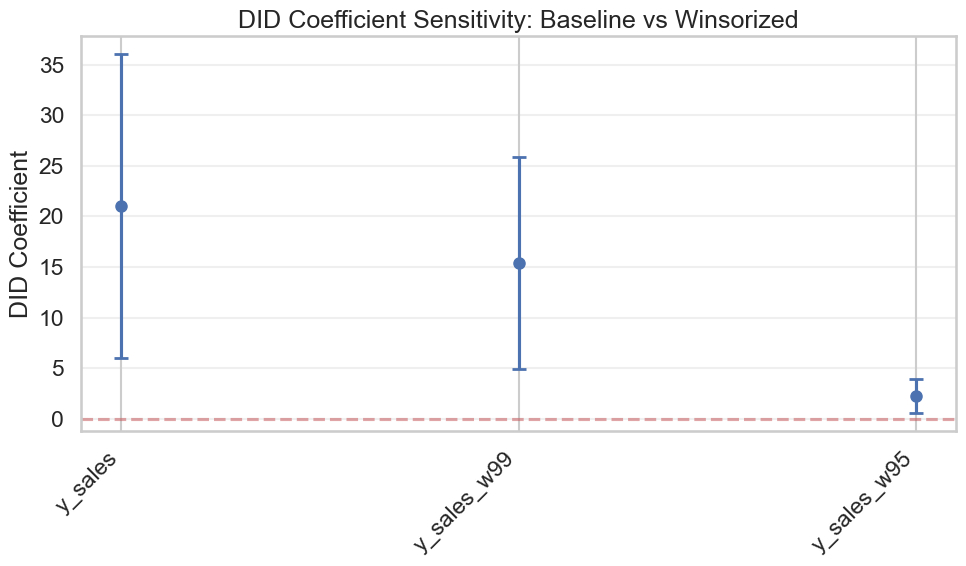

In [9]:
df_panel["y_sales_w99"] = mstats.winsorize(df_panel["y_sales"], limits=[0.01, 0.01])
df_panel["y_sales_w95"] = mstats.winsorize(df_panel["y_sales"], limits=[0.05, 0.05])

winsor_outcomes = ["y_sales", "y_sales_w99", "y_sales_w95"]
winsor_results = []

for outcome in winsor_outcomes:
    logger.info(f"Fitting TWFE for {outcome}")
    result = run_twfe(df_panel, outcome)
    
    did_idx = result.param_names.index("did")
    winsor_results.append({
        "outcome": outcome,
        "coef": result.params.iloc[did_idx],
        "se_clustered": result.bse.iloc[did_idx],
        "pvalue": result.pvalues.iloc[did_idx],
        "ci_low": result.conf_int().iloc[did_idx, 0],
        "ci_high": result.conf_int().iloc[did_idx, 1]
    })

df_winsor = pd.DataFrame(winsor_results)
df_winsor.to_csv(TABLE_DIR / "twfe_winsor_sensitivity.csv", index=False)

print(df_winsor)

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(winsor_outcomes))
coefs = df_winsor["coef"].values
errors = [df_winsor["coef"].values - df_winsor["ci_low"].values, 
          df_winsor["ci_high"].values - df_winsor["coef"].values]
errors = np.array(errors)

ax.errorbar(x_pos, coefs, yerr=errors, fmt='o', capsize=5, capthick=2, markersize=8)
ax.set_xticks(x_pos)
ax.set_xticklabels(winsor_outcomes, rotation=45, ha='right')
ax.set_ylabel("DID Coefficient")
ax.set_title("DID Coefficient Sensitivity: Baseline vs Winsorized")
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')
fig.tight_layout()
fig.savefig(FIG_DIR / "did_coef_sensitivity_sales.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## LOHO Sensitivity


2026-01-14 19:01:48,046 - INFO - Running LOHO for y_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.

    outcome  dropped_household_id       coef        se    pvalue
0   y_sales                     8  23.666818  9.496757  0.012699
1   y_sales                    12  22.748782  8.187042  0.005459
2   y_sales                    13  18.419737  6.175764  0.002858
3   y_sales                    18  23.258846  8.318258  0.005172
4   y_sales                    20  22.547627  7.598525  0.003004
5   y_sales                    22  22.571029  8.233295  0.006117
6   y_sales                    23  22.340111  8.185012  0.006345
7   y_sales                    29  21.062008  7.944138  0.008019
8   y_sales                    14  20.981205  8.161378  0.010147
9   y_sales                     7  20.648693  7.872515  0.008719
10  y_sales                     9  18.723171  7.569904  0.013385
11  y_sales                    10  18.862896  7.490921  0.011799
12  y_sales                    16  20.603050  7.717107  0.007590
13  y_sales                     4  20.189171  8.036500  0.011999
14  y_sales              

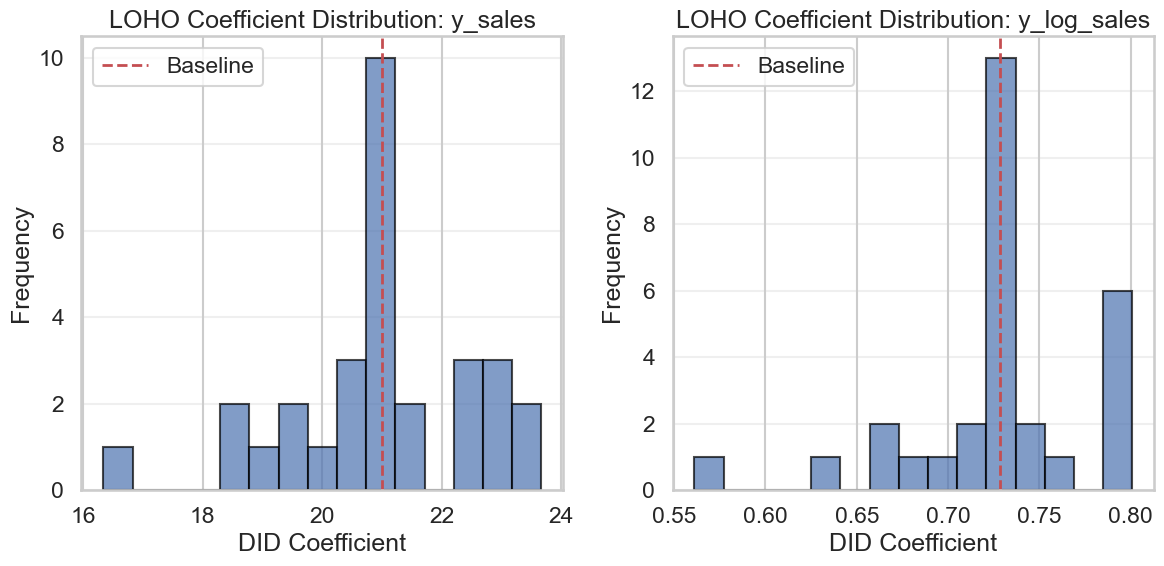

In [10]:
loho_outcomes = ["y_sales", "y_log_sales"]
loho_results = []

for outcome in loho_outcomes:
    logger.info(f"Running LOHO for {outcome}")
    baseline_result = baseline_results[outcome]
    did_idx = baseline_result.param_names.index("did")
    baseline_coef = baseline_result.params.iloc[did_idx]
    
    for hh_id in df_panel["household_id"].unique():
        df_dropped = df_panel[df_panel["household_id"] != hh_id].copy()
        if len(df_dropped) < 10:
            continue
        
        try:
            result = run_twfe(df_dropped, outcome)
            loho_results.append({
                "outcome": outcome,
                "dropped_household_id": hh_id,
                "coef": result.params.iloc[did_idx],
                "se": result.bse.iloc[did_idx],
                "pvalue": result.pvalues.iloc[did_idx]
            })
        except Exception as e:
            logger.warning(f"LOHO failed for household {hh_id}, outcome {outcome}: {e}")

df_loho = pd.DataFrame(loho_results)
df_loho.to_csv(TABLE_DIR / "loho_did_coefs.csv", index=False)

print(df_loho.head(20))

for outcome in loho_outcomes:
    df_outcome = df_loho[df_loho["outcome"] == outcome]
    if len(df_outcome) == 0:
        continue
    
    baseline_coef = baseline_results[outcome].params.iloc[baseline_results[outcome].param_names.index("did")]
    loho_coefs = df_outcome["coef"].values
    
    min_coef = loho_coefs.min()
    max_coef = loho_coefs.max()
    pct_5 = np.percentile(loho_coefs, 5)
    pct_95 = np.percentile(loho_coefs, 95)
    same_sign_pct = (np.sign(loho_coefs) == np.sign(baseline_coef)).mean() * 100
    in_band = (pct_5 <= baseline_coef <= pct_95)
    
    logger.info(f"{outcome} LOHO stats:")
    logger.info(f"  Min: {min_coef:.4f}, Max: {max_coef:.4f}")
    logger.info(f"  5th-95th percentile: [{pct_5:.4f}, {pct_95:.4f}]")
    logger.info(f"  Baseline coef: {baseline_coef:.4f} (in band: {in_band})")
    logger.info(f"  Same sign as baseline: {same_sign_pct:.1f}%")

fig, axes = plt.subplots(1, len(loho_outcomes), figsize=(6*len(loho_outcomes), 6))
if len(loho_outcomes) == 1:
    axes = [axes]

for idx, outcome in enumerate(loho_outcomes):
    df_outcome = df_loho[df_loho["outcome"] == outcome]
    if len(df_outcome) == 0:
        continue
    
    baseline_coef = baseline_results[outcome].params.iloc[baseline_results[outcome].param_names.index("did")]
    axes[idx].hist(df_outcome["coef"].values, bins=15, alpha=0.7, edgecolor='black')
    axes[idx].axvline(baseline_coef, color='r', linestyle='--', linewidth=2, label='Baseline')
    axes[idx].set_xlabel("DID Coefficient")
    axes[idx].set_ylabel("Frequency")
    axes[idx].set_title(f"LOHO Coefficient Distribution: {outcome}")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
fig.savefig(FIG_DIR / "loho_coef_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Placebo Pre-Period Test


2026-01-14 19:03:27,557 - INFO - Fitting placebo TWFE for y_sales
/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
2026-01-14 19:03:27,884 - INFO - Fitting placebo TWFE for y_log_sales


       outcome       coef  se_clustered    pvalue    ci_low    ci_high
0      y_sales  18.970632      9.468924  0.045128  0.411882  37.529383
1  y_log_sales   0.688832      0.334514  0.039475  0.033196   1.344468


/Users/rajnishpanwar/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


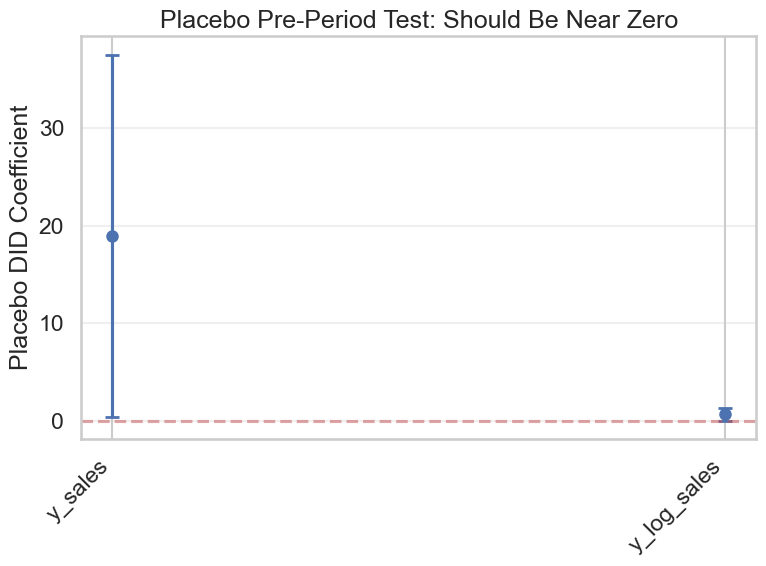

In [11]:
df_pre = df_panel[df_panel["rel_week"] < 0].copy()
df_pre["placebo_post"] = (df_pre["rel_week"] >= -4).astype(int)
df_pre["placebo_did"] = df_pre["treated"] * df_pre["placebo_post"]

placebo_outcomes = ["y_sales", "y_log_sales"]
placebo_results = []

for outcome in placebo_outcomes:
    logger.info(f"Fitting placebo TWFE for {outcome}")
    
    y = df_pre[outcome].values
    X_did = pd.DataFrame({"placebo_did": df_pre["placebo_did"].astype(float)})
    X_hh = pd.get_dummies(df_pre["household_id"], prefix="hh", drop_first=True, dtype=float)
    X_week = pd.get_dummies(df_pre["week_number"], prefix="week", drop_first=True, dtype=float)
    
    X = pd.concat([X_did, X_hh, X_week], axis=1)
    X = add_constant(X, prepend=False)
    X = X.astype(float)
    
    model = OLS(y, X)
    result = model.fit(cov_type="cluster", cov_kwds={"groups": df_pre["household_id"]})
    
    did_idx = X.columns.tolist().index("placebo_did")
    placebo_results.append({
        "outcome": outcome,
        "coef": result.params.iloc[did_idx],
        "se_clustered": result.bse.iloc[did_idx],
        "pvalue": result.pvalues.iloc[did_idx],
        "ci_low": result.conf_int().iloc[did_idx, 0],
        "ci_high": result.conf_int().iloc[did_idx, 1]
    })

df_placebo = pd.DataFrame(placebo_results)
df_placebo.to_csv(TABLE_DIR / "placebo_preperiod.csv", index=False)

print(df_placebo)

fig, ax = plt.subplots(figsize=(8, 6))
x_pos = np.arange(len(placebo_outcomes))
coefs = df_placebo["coef"].values
errors = [df_placebo["coef"].values - df_placebo["ci_low"].values,
          df_placebo["ci_high"].values - df_placebo["coef"].values]
errors = np.array(errors)

ax.errorbar(x_pos, coefs, yerr=errors, fmt='o', capsize=5, capthick=2, markersize=8)
ax.set_xticks(x_pos)
ax.set_xticklabels(placebo_outcomes, rotation=45, ha='right')
ax.set_ylabel("Placebo DID Coefficient")
ax.set_title("Placebo Pre-Period Test: Should Be Near Zero")
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')
fig.tight_layout()
fig.savefig(FIG_DIR / "placebo_effects.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## SE Comparison Plot


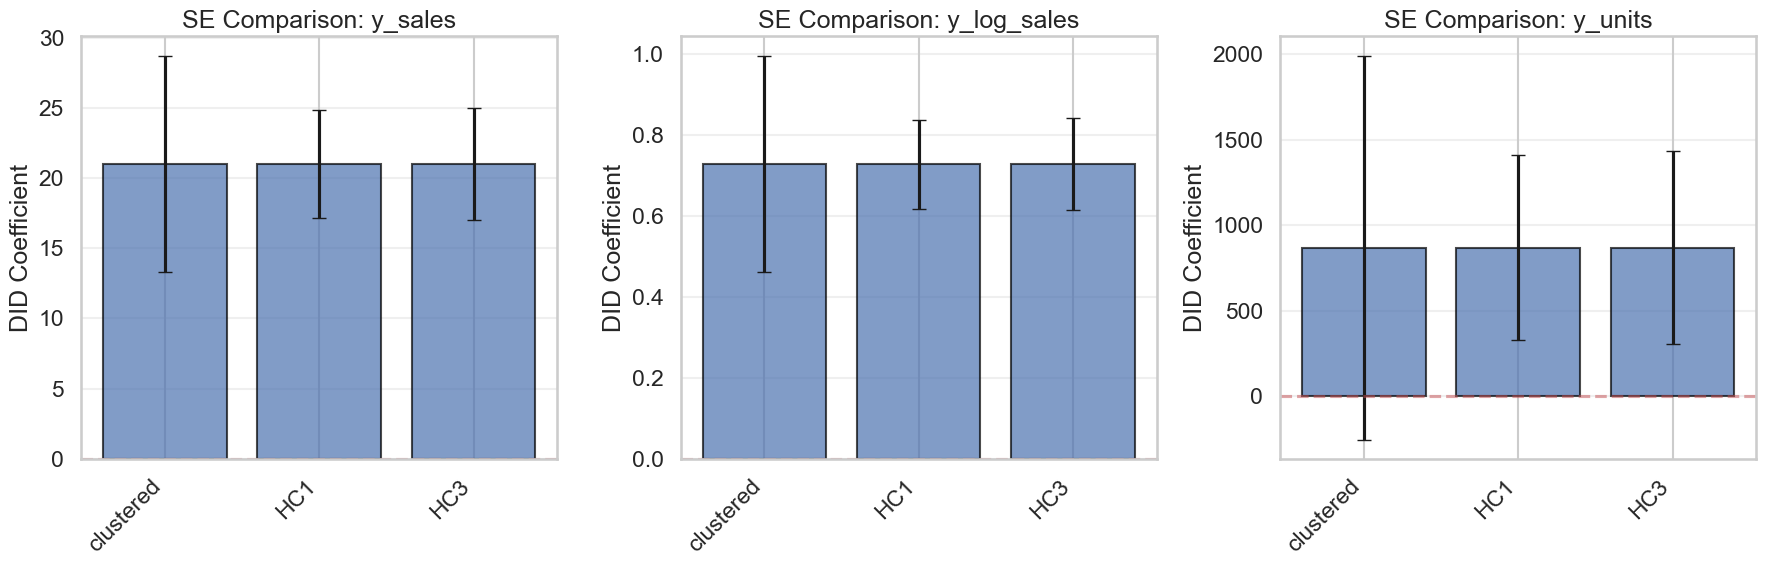

In [13]:
fig, axes = plt.subplots(1, len(outcomes), figsize=(6*len(outcomes), 6))
if len(outcomes) == 1:
    axes = [axes]

for idx, outcome in enumerate(outcomes):
    df_outcome = df_se_comparison[df_se_comparison["outcome"] == outcome]
    
    x_pos = np.arange(len(df_outcome))
    coefs = df_outcome["coef"].values
    ses = df_outcome["se"].values
    
    axes[idx].bar(x_pos, coefs, yerr=ses, capsize=5, alpha=0.7, edgecolor='black')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(df_outcome["se_type"].values, rotation=45, ha='right')
    axes[idx].set_ylabel("DID Coefficient")
    axes[idx].set_title(f"SE Comparison: {outcome}")
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[idx].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
fig.savefig(FIG_DIR / "se_comparison_bar.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Run Manifest


In [14]:
def get_package_versions() -> Dict[str, str]:
    versions = {}
    for pkg in ["pandas", "numpy", "statsmodels", "matplotlib", "seaborn", "scipy"]:
        try:
            mod = __import__(pkg)
            versions[pkg] = getattr(mod, "__version__", "unknown")
        except ImportError:
            versions[pkg] = "not_installed"
    return versions

loho_stability = {}
for outcome in loho_outcomes:
    df_outcome = df_loho[df_loho["outcome"] == outcome]
    if len(df_outcome) > 0:
        baseline_coef = baseline_results[outcome].params.iloc[baseline_results[outcome].param_names.index("did")]
        loho_coefs = df_outcome["coef"].values
        pct_5 = np.percentile(loho_coefs, 5)
        pct_95 = np.percentile(loho_coefs, 95)
        same_sign_pct = (np.sign(loho_coefs) == np.sign(baseline_coef)).mean() * 100
        in_band = bool(pct_5 <= baseline_coef <= pct_95)
        
        loho_stability[outcome] = {
            "min_coef": float(loho_coefs.min()),
            "max_coef": float(loho_coefs.max()),
            "pct_5": float(pct_5),
            "pct_95": float(pct_95),
            "baseline_in_band": in_band,
            "same_sign_pct": float(same_sign_pct)
        }

output_files = [
    str(TABLE_DIR / "twfe_baseline.csv"),
    str(TABLE_DIR / "twfe_se_comparison.csv"),
    str(TABLE_DIR / "twfe_winsor_sensitivity.csv"),
    str(TABLE_DIR / "loho_did_coefs.csv"),
    str(TABLE_DIR / "placebo_preperiod.csv"),
    str(FIG_DIR / "did_coef_sensitivity_sales.png"),
    str(FIG_DIR / "loho_coef_distribution.png"),
    str(FIG_DIR / "se_comparison_bar.png"),
    str(FIG_DIR / "placebo_effects.png")
]

manifest = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "python_executable": sys.executable,
    "package_versions": get_package_versions(),
    "input_files": [str(panel_file)],
    "output_files": output_files,
    "key_stats": {
        "n_rows": int(n_rows),
        "n_households": int(n_households),
        "n_campaigns": int(n_campaigns),
        "treated_row_share": float(treated_row_share),
        "treated_household_count": int(treated_household_count)
    },
    "baseline_did_coefs": df_baseline.set_index("outcome")[["coef", "se_clustered", "pvalue"]].to_dict(orient="index"),
    "loho_stability": loho_stability
}

manifest_file = RUN_MANIFESTS_DIR / f"twfe_robustness_manifest_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}.json"
with open(manifest_file, 'w') as f:
    json.dump(manifest, f, indent=2)

logger.info(f"Run manifest saved to {manifest_file}")


2026-01-14 19:05:22,663 - INFO - Run manifest saved to /Users/rajnishpanwar/Desktop/Casual Analytics/results/run_manifests/twfe_robustness_manifest_20260114_190522.json
